<a href="https://colab.research.google.com/github/csymvoul/influential-instances-identification/blob/main/Influential_Instances_Conference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Deletion Diagnostics for the identification of Influential Instances towards Causal-based learning


The steps needed to train an AI model based on the influential instances are:

1. Train the model on the original dataset
2. Calculate the DFBETA and RMSE values for each instance: 
 * $DFBETA_{i}=\beta-\beta^{-i}$, where $\beta$ is the weight vector of the initial model that is trained with all instances and $\beta^{-i}$ is the weight vector of the initial model that is trained without the $i$-th instance.
 * The $\beta^{-i}$ is calculated by training the model on the dataset without the $i$-th instance.
 * $RMSE_i = \sqrt{\frac{1}{n} \times \sum_{j=1}^{n}{(y_j - \hat{y_j})^2}}$, where {i} is the removed instance, $n$ is the number of instances, $y_j$ is the correct value $\hat{y_j}$ is the predicted value.

3. Once the $DFBETA$ and $RMSE$ values are calculated, the influential instances are the ones with the highest $DFBETA$ and lowest $RMSE$ values
4. Then only the influential instances are kept from the original dataset
5. Consequently, we apply the K-Means algorithm, where $K$ is equal to the number influential instances and we apply it to the excluded data of the original dataset
6. The centroids of the K-Means algorithm are the influential instances
7. We cluster the original dataset based on the centroids of the K-Means algorithm and we produce a new final dataset, which we use to re-train the model 



## Import Libraries and connect to Google Drive

### Import Libraries 

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, MaxPooling3D, Flatten
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, Conv3D

In [5]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
!python -m pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 5.1 MB/s 


In [7]:
from tslearn.metrics import dtw

### Connect to Google Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download dataset

In [9]:
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url,sep=",")
print(data)

            Date  Consumption     Wind   Solar  Wind+Solar
0     2006-01-01   1069.18400      NaN     NaN         NaN
1     2006-01-02   1380.52100      NaN     NaN         NaN
2     2006-01-03   1442.53300      NaN     NaN         NaN
3     2006-01-04   1457.21700      NaN     NaN         NaN
4     2006-01-05   1477.13100      NaN     NaN         NaN
...          ...          ...      ...     ...         ...
4378  2017-12-27   1263.94091  394.507  16.530     411.037
4379  2017-12-28   1299.86398  506.424  14.162     520.586
4380  2017-12-29   1295.08753  584.277  29.854     614.131
4381  2017-12-30   1215.44897  721.247   7.467     728.714
4382  2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 5 columns]


## Pre-processing

In [10]:
# Check if there exist any rows with 0 values 

print(data.loc[data['Consumption'] == 0])
print(data.loc[data['Wind'] == 0])
print(data.loc[data['Solar'] == 0])
print(data.loc[data['Wind+Solar'] == 0])

Empty DataFrame
Columns: [Date, Consumption, Wind, Solar, Wind+Solar]
Index: []
Empty DataFrame
Columns: [Date, Consumption, Wind, Solar, Wind+Solar]
Index: []
Empty DataFrame
Columns: [Date, Consumption, Wind, Solar, Wind+Solar]
Index: []
Empty DataFrame
Columns: [Date, Consumption, Wind, Solar, Wind+Solar]
Index: []


In [11]:
# Use Date as the index 
data = data.set_index('Date')
data.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


In [12]:
# Check number of NaNs 
data.isnull().sum()

Consumption       0
Wind           1463
Solar          2195
Wind+Solar     2196
dtype: int64

In [13]:
data_without_nan = data.fillna(0)

In [14]:
df = data_without_nan
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,0.0,0.0,0.0
2006-01-02,1380.521,0.0,0.0,0.0
2006-01-03,1442.533,0.0,0.0,0.0
2006-01-04,1457.217,0.0,0.0,0.0
2006-01-05,1477.131,0.0,0.0,0.0


## LSTM Model 

### Convert series to supervised

In [15]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    if isinstance(data, list):
        n_vars = 1
    else:
        n_vars = data.shape[1]
    if isinstance(data, pd.DataFrame):
        pass
    else:
        data = pd.DataFrame(data)
    cols, names = list(), list()
    print(n_vars)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        print(i)
        cols.append(data.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    #cols_to_use = names[:len(names) - (n_out)]
    #agg = agg[cols_to_use]
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


new_df = series_to_supervised(data,n_in= 1, n_out=1)

4
1


In [16]:
print(new_df.head())

            var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)  var2(t)  \
Date                                                                        
2012-01-02    948.128    227.465      6.587    234.052  1269.581  207.327   
2012-01-03   1269.581    207.327      6.574    213.901  1334.745  473.468   
2012-01-04   1334.745    473.468     24.679    498.147  1347.136  499.804   
2012-01-05   1347.136    499.804     14.681    514.485  1376.658  523.851   
2012-01-06   1376.658    523.851      5.071    528.922  1291.215  286.265   

            var3(t)  var4(t)  
Date                          
2012-01-02    6.574  213.901  
2012-01-03   24.679  498.147  
2012-01-04   14.681  514.485  
2012-01-05    5.071  528.922  
2012-01-06   13.160  299.425  


### Min Max scaler

In [17]:
def Min_max_scal(data):
	array = data.values
	values_ = array.astype('float32')
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled = scaler.fit_transform(values_)
	return scaled

In [18]:
columns = new_df.columns
scaled_np = Min_max_scal(new_df)
scaled_df = pd.DataFrame(scaled_np, columns=[columns])

scaled_df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
0,-0.876496,-0.460935,-0.961446,-0.487822,-0.054549,-0.510066,-0.961555,-0.536374
1,-0.054549,-0.510066,-0.961555,-0.536374,0.112073,0.139243,-0.810435,0.148492
2,0.112073,0.139243,-0.810435,0.148492,0.143757,0.203496,-0.893887,0.187857
3,0.143757,0.203496,-0.893887,0.187857,0.219244,0.262164,-0.974100,0.222642
4,0.219244,0.262164,-0.974100,0.222642,0.000768,-0.317479,-0.906582,-0.330311


### Split into train and test datasets

In [19]:
def reshape_data_single_lag(reframed, train_percentage, test_percentage, valid_percentage):
	# split into train and test sets
	values = reframed.values
	# Sizes
	train_size = int(len(reframed) * train_percentage)
	test_size = int(len(reframed) * test_percentage)
	valid_size = int(len(reframed) * valid_percentage)

	train = values[:train_size]
	test = values[train_size:train_size + test_size]
	val = values[train_size + test_size:]

	# split into input and outputs
	train_X, train_y = train[:, :-1], train[:, -1]
	test_X, test_y = test[:, :-1], test[:, -1]
	val_X, val_y = val[:, :-1], val[:, -1]
	# print(train_X.shape)

	### this reshape below is we using it for univariate timeseries
	# reshape input to be 3D [samples, timesteps, features]
	train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
	test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
	val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

	print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

	return train_X, train_y, test_X, test_y, val_X, val_y

In [20]:
scaled_df.shape

(2183, 8)

In [22]:
scaled_df1  = scaled_df[:1000]
train_X, train_y, test_X, test_y, val_X, val_y = reshape_data_single_lag(scaled_df1,  0.65, 0.25, 0.10 )

(650, 1, 7) (650,) (250, 1, 7) (250,) (100, 1, 7) (100,)


In [23]:
np.save('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/train_X.npy', train_X)
np.save('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/train_y.npy', train_y)
np.save('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/test_X.npy', test_X)
np.save('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/test_y.npy', test_y)

### Train model

In [24]:
def LSTM_model(train_X, train_y, test_X, test_y):
    # design network
    model = Sequential()
    model.add(LSTM(90, return_sequences = True,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.75))
    model.add(LSTM(70, return_sequences = True,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.75))
    model.add(LSTM(50, return_sequences = True,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.50))
    model.add(LSTM(30, return_sequences = True,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.50))
    model.add(LSTM(10, return_sequences = False,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.10))
    #model.add(LSTM(15, return_sequences = False ))
    #model.add(Dropout(0.5))
    #model.add(LSTM(30, return_sequences = False ))
    #model.add(Dropout(0.2))
    #model.add(LSTM(15, return_sequences = False ))
    #model.add(Dense(50))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_X, train_y, epochs=25, batch_size=8, validation_data=(test_X, test_y),verbose=2, shuffle=False)
    return model

In [25]:
model = LSTM_model(train_X, train_y, test_X, test_y)

Epoch 1/25
82/82 - 17s - loss: 0.2160 - val_loss: 0.0697 - 17s/epoch - 205ms/step
Epoch 2/25
82/82 - 1s - loss: 0.0555 - val_loss: 0.0592 - 829ms/epoch - 10ms/step
Epoch 3/25
82/82 - 1s - loss: 0.0486 - val_loss: 0.0593 - 833ms/epoch - 10ms/step
Epoch 4/25
82/82 - 1s - loss: 0.0429 - val_loss: 0.0574 - 833ms/epoch - 10ms/step
Epoch 5/25
82/82 - 1s - loss: 0.0451 - val_loss: 0.0525 - 870ms/epoch - 11ms/step
Epoch 6/25
82/82 - 1s - loss: 0.0392 - val_loss: 0.0489 - 846ms/epoch - 10ms/step
Epoch 7/25
82/82 - 1s - loss: 0.0324 - val_loss: 0.0452 - 770ms/epoch - 9ms/step
Epoch 8/25
82/82 - 1s - loss: 0.0327 - val_loss: 0.0347 - 818ms/epoch - 10ms/step
Epoch 9/25
82/82 - 1s - loss: 0.0272 - val_loss: 0.0235 - 838ms/epoch - 10ms/step
Epoch 10/25
82/82 - 1s - loss: 0.0211 - val_loss: 0.0132 - 861ms/epoch - 10ms/step
Epoch 11/25
82/82 - 1s - loss: 0.0180 - val_loss: 0.0089 - 850ms/epoch - 10ms/step
Epoch 12/25
82/82 - 1s - loss: 0.0148 - val_loss: 0.0047 - 848ms/epoch - 10ms/step
Epoch 13/25
82

#### Model summary 

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 90)             35280     
                                                                 
 dropout (Dropout)           (None, 1, 90)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 70)             45080     
                                                                 
 dropout_1 (Dropout)         (None, 1, 70)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             24200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 1, 30)             9

#### Plot model loss

In [27]:
def plot_train_test_loss(model):
    mpl.rcParams['figure.figsize'] = (12, 8)
    mpl.rcParams['axes.grid'] = False
    
    # plot history
    plt.plot(model.history.history['loss'], label='train')
    plt.plot(model.history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

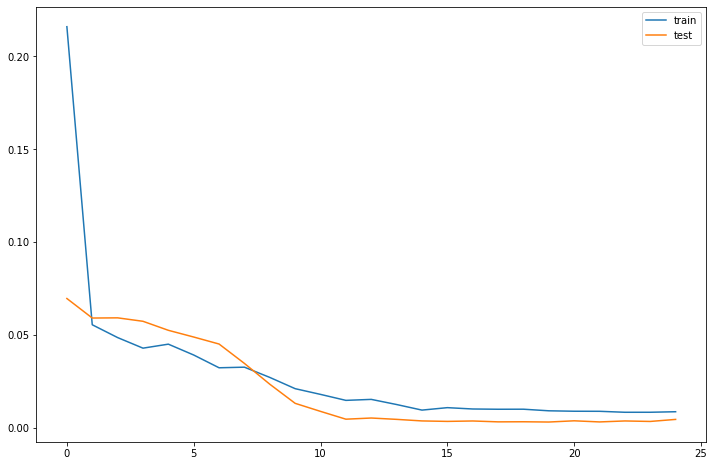

In [28]:
plot_train_test_loss(model)

### Predictions and scores 

In [29]:
def predictions_and_scores_for_LSTM(model, test_X,test_y):
	# make a prediction
	yhat = model.predict(test_X)
	# test_X_reshaped = test_X.reshape((test_X.shape[0], 3*2))
	yhat_reshaped = yhat.reshape((yhat.shape[0], yhat.shape[1]))

	test_y_reshaped = test_y.reshape((len(test_y), 1))

	# calculate RMSE and R2_score
	rmse = sqrt(mean_squared_error(test_y_reshaped, yhat_reshaped))
	r2score = r2_score(test_y_reshaped, yhat_reshaped)
	
	print('Test RMSE: %.3f' % rmse)
	print('R2_score: %f' % r2score)
	return rmse, r2score

In [30]:
predictions_and_scores_for_LSTM(model, test_X, test_y)

8/8 [==============================] - 2s 4ms/step
Test RMSE: 0.068
R2_score: 0.942207


(0.06765374365672652, 0.9422072342410255)

## Influential Instances identification

In [31]:
# The weights of the first model without deleting one or more instances
initial_model_weights = model.get_weights()
len(initial_model_weights)

17

### Calculate $\beta$, $RMSE$ and $R^2$

In [ ]:
model_weights = []
rmse = []
r2score = []

j = 0
for index, i in enumerate(train_X):
  train_X_without_i = np.delete(train_X, index, 0)
  train_y_without_i = np.delete(train_y, index, 0)
  model_without_i = LSTM_model(train_X_without_i, train_y_without_i, test_X, test_y)
  rmse_without_i, r2score_without_i = predictions_and_scores_for_LSTM(model_without_i, train_X_without_i, train_y_without_i)
  model_weights += model_without_i.get_weights()
  rmse.append(rmse_without_i)
  r2score.append(r2score_without_i)
  j+=1
  print(j)

21/21 [==============================] - 2s 5ms/step
Test RMSE: 0.035
R2_score: 0.974912
83
Epoch 1/25
82/82 - 13s - loss: 0.2264 - val_loss: 0.0671 - 13s/epoch - 156ms/step
Epoch 2/25
82/82 - 1s - loss: 0.0547 - val_loss: 0.0594 - 817ms/epoch - 10ms/step
Epoch 3/25
82/82 - 1s - loss: 0.0493 - val_loss: 0.0579 - 864ms/epoch - 11ms/step
Epoch 4/25
82/82 - 1s - loss: 0.0460 - val_loss: 0.0553 - 828ms/epoch - 10ms/step
Epoch 5/25
82/82 - 1s - loss: 0.0440 - val_loss: 0.0527 - 1s/epoch - 15ms/step
Epoch 6/25
82/82 - 2s - loss: 0.0407 - val_loss: 0.0490 - 2s/epoch - 19ms/step
Epoch 7/25
82/82 - 1s - loss: 0.0375 - val_loss: 0.0442 - 897ms/epoch - 11ms/step
Epoch 8/25
82/82 - 1s - loss: 0.0312 - val_loss: 0.0355 - 823ms/epoch - 10ms/step
Epoch 9/25
82/82 - 1s - loss: 0.0283 - val_loss: 0.0286 - 852ms/epoch - 10ms/step
Epoch 10/25
82/82 - 3s - loss: 0.0244 - val_loss: 0.0176 - 3s/epoch - 34ms/step
Epoch 11/25
82/82 - 1s - loss: 0.0192 - val_loss: 0.0103 - 866ms/epoch - 11ms/step
Epoch 12/25
8

### Store scores into files

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/r2_score_list.txt", "w") as f:
    for s in r2score:
        f.write(str(s) +"\n")


with open("/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/r2_score_list.txtrmse_list.txt", "w") as f:
    for s in rmse:
        f.write(str(s) +"\n")

### $DFBETA$ calculation

In [ ]:
total_weights = int(len(model_weights)/len(initial_model_weights))
count=0
# print(len(model_weights))
# print(len(initial_model_weights))

# for i in range(0, 2):
count = 0
dfbeta_all = []
dfbeta_sum = []
for i in range(0, len(model_weights)):
  dfbeta = np.subtract(initial_model_weights[i-count], model_weights[i])
  dfbeta_all.append(dfbeta)
  if (i % len(initial_model_weights)==0):
    count+=len(initial_model_weights)
    dfbeta_sum.append(np.sum(dfbeta))

with open("/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/dfbeta.csv", "w") as f:
    for s in dfbeta_sum:
        f.write(str(s) +"\n")


dfbeta_sum_abs = np.abs(dfbeta_sum)
dfbeta_sum = np.array(dfbeta_sum)

In [ ]:
most_influential_instances_indices = []
number_of_influential_instances = len(dfbeta_sum)
for i in range(0, number_of_influential_instances):
  most_influential_instances_indices.append(np.argmax(dfbeta_sum))
  dfbeta_sum[np.argmax(dfbeta_sum)] = -1000

most_influential_instances_indices

In [ ]:
influential_instances = []
for i in range(0, len(most_influential_instances_indices)):
  influential_instances.append(scaled_df1.values.tolist())

influential_instances

### Sort instances according to $RMSE$

In [ ]:
# Storing RMSE to a file 
rmse_np = np.array(rmse)

np.savetxt("/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/rmse.csv", rmse_np, delimiter=",")

In [ ]:
rmse_np = np.array(rmse)
least_rmse_indices = []
for i in range(0, len(rmse)):
  least_rmse_indices.append(np.argmin(rmse_np))
  rmse_np[np.argmin(rmse_np)] = 99999

least_rmse_indices

### Sort instances according to $R^2$

In [ ]:
# Storing R2 to a file 
r2_score_np = np.array(r2_score)

numpy.savetxt("/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/r2_score.csv", r2_score_np, delimiter=",")

In [ ]:
r2score_np = np.array(r2score)
highest_r2score_indices = []
for i in range(0, len(r2score)):
  highest_r2score_indices.append(np.argmax(r2score_np))
  r2score_np[np.argmax(r2score_np)] = -100

highest_r2score_indices

### Merge $RMSE$, $R^2$, and $DFBETA$ to one dataframe

In [ ]:
metrics = np.column_stack([most_influential_instances_indices, least_rmse_indices, highest_r2score_indices])
metrics_df = pd.DataFrame(metrics)

from google.colab import files
metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/metrics.csv')
files.download('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/metrics.csv')

#### Store metrics to csv files

In [ ]:
r2score_df =  pd.DataFrame(r2score)

from google.colab import files
r2score_df.to_csv('r2score.csv')
files.download('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/r2score.csv')

In [ ]:
rmse_df =  pd.DataFrame(rmse)

from google.colab import files
rmse_df.to_csv('rmse.csv')
files.download('rmse.csv')

In [ ]:
model_weights_df = pd.DataFrame(model_weights)

from google.colab import files
model_weights_df.to_csv('model_weights.csv')
files.download('model_weights.csv')

### Creating a DataFrame with $DFBETA$, and $RMSE$



In [ ]:
dfbeta = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/dfbeta.csv', delimiter=',')
rmse = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/rmse_list.txt', delimiter=',')
r2_score = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/results/r2_score_list.txt', delimiter=',')

In [ ]:
metrics_df = pd.DataFrame()
metrics_df['rmse'] = rmse.tolist()
metrics_df['dfbeta'] = dfbeta.tolist()
metrics_df['dfbeta_abs'] = abs(metrics_df['dfbeta'])
metrics_df

In [ ]:
dfbeta_accepted_value = dfbeta.std()+dfbeta.mean()
rmse_accepted_value = rmse.std()+rmse.mean()

filtered_metrics_df = metrics_df[
                           (metrics_df['dfbeta_abs'] > dfbeta_accepted_value) & (metrics_df['rmse'] > rmse_accepted_value)
                        ]
print(f"Number of identified Influential Instances: {len(filtered_metrics_df)}")
filtered_metrics_df.head()

#### Getting indices of Influential Instances

In [ ]:
indices_of_influential_instances = filtered_metrics_df.index
indices_of_influential_instances.tolist()

In [ ]:
influential_instances = np.array(train_X)[indices_of_influential_instances]

### Calculating distances using the Dynamic Time Warping Matching metric

In [ ]:
dtw_distance = []

for index, instance in enumerate(train_X):
    for index1, instance1 in enumerate(train_X):
        dtw_distance.append(dtw(instance, instance1))

In [ ]:
indices_of_influential_instances = indices_of_influential_instances.tolist()
indices_of_influential_instances

In [ ]:
threshold_distance = 0.3*np.mean(dtw_distance)+0.1*np.std(dtw_distance)
print(f'{threshold_distance}')

newly_identified_influential_instances = []
for ii_index, influential_instance in enumerate(influential_instances):
    for i_index, instance in enumerate(train_X):
        distance = dtw(influential_instance, instance)

        if (distance <= threshold_distance and distance != 0 and i_index not in newly_identified_influential_instances):
            newly_identified_influential_instances.append(i_index)
            indices_of_influential_instances.append(i_index)

In [ ]:
indices_of_influential_instances_without_duplicates = list(dict.fromkeys(indices_of_influential_instances))
len(indices_of_influential_instances_without_duplicates)

### Creating dataset that only includes influential instances

In [ ]:
influential_instances_X = np.array(train_X)[indices_of_influential_instances_without_duplicates]
influential_instances_y = np.array(train_y)[indices_of_influential_instances_without_duplicates]

#### Storing new dataset

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/influential_instances_train_X.npy', influential_instances_X)
np.save('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/influential_instances_train_y.npy', influential_instances_y)

### Re-train LSTM model with new influential instances dataset

#### Retrieving train and test sets

In [ ]:
train_X = np.load('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/influential_instances_train_X.npy')
train_y = np.load('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/influential_instances_train_y.npy')
test_X = np.load('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/test_X.npy')
test_y = np.load('/content/drive/MyDrive/Colab Notebooks/influential_instances_conf/datasets/test_y.npy')

In [ ]:
model = LSTM_model(train_X, train_y, test_X, test_y)

#### Model summary

In [ ]:
model.summary()

#### Plot model loss 

In [ ]:
plot_train_test_loss(model)